# Проект по матчингу (поиску соответствий)

## Описание проекта

Мы имеем датасет, предоставленный некоторым маркетплейсом, представляющий собой анонимизированный набор товаров. Каждый товар имеет уникальный id и вектор числовых признаков. Нам необходимо решить задачу матчинга, то есть поиска наиболее похожих товаров. 

Исходные данные:  
- base.csv - анонимизированный набор товаров. Каждый товар представлен как уникальный id (0-base, 1-base, ...) и вектор признаков размерностью 72.
- target.csv - обучающий датасет. Каждая строчка - один товар, для которого известен уникальный id (0-query, 1-query, ...), вектор признаков и id товара из base.csv, который максимально похож на него (по мнению экспертов).  
- validation.csv - датасет с товарами(уникальный id и вектор признаков), для которых нужно найтинаиболее близкие товары из base.csv. 
- validation_answer.csv - правильные ответы к validation.csv.

Задача:  
- разработать алгоритм, который для всех товаров из validation.csv предложит несколько вариантов наиболее похожих товаров из base;  
- оценить качество алгоритма по метрике accuracy@5.

Этапы выполнения проекта:  
- загрузка данных и необходимых библиотек;  
- подготовка baseline решения;  
- проведение EDA;  
- повышение качества работы алгоритма;
- реальзация второго этапа ранжирования;
- вывод.

## Загрузка данных и необходимых библиотек

Загрузим необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
import faiss
from tqdm import tqdm

from matplotlib import pyplot as plt

from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight

import catboost as cb

c:\Users\alex3\anaconda3\envs\ds_practicum_env\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
pd.set_option('display.max_columns', 80)

Подготовка словаря для конкретной загрузки типов данных

In [3]:
dict_base = {}
for i in range(72):
    dict_base[str(i)] = 'float32'
dict_base
dict_train = dict_base.copy()
dict_train['Target'] = 'str'

In [4]:
len(dict_base)

72

Загрузим датасеты

In [5]:
data_base = pd.read_table("../../../Education/DS+/Projects/masterskaya_2/data/base.csv", index_col=0, sep=',', dtype=dict_base)
data_train = pd.read_table("../../../Education/DS+/Projects/masterskaya_2/data/train.csv", index_col=0, sep=',', dtype=dict_base)
data_validation = pd.read_table("../../../Education/DS+/Projects/masterskaya_2/data/validation.csv", index_col=0, sep=',', dtype=dict_base)
data_answer = pd.read_table("../../../Education/DS+/Projects/masterskaya_2/data/validation_answer.csv", index_col=0, sep=',', dtype=dict_base)

In [6]:
for df in [data_base, data_train, data_validation, data_answer]:
    display(df.shape)
    display(df.head())

(2918139, 72)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083893,11.152912,-64.426758,-118.880890,216.482437,-104.698059,-469.070587,44.348083,120.915344,181.449707,-124.061508,-32.458237,-57.420559,36.207405,182.716766,-28.071688,-5.209374,-1.732183,-91.091858,-79.466667,-103.939087,1507.231323,-32.591667,51.414360,-51.905361,813.770081,-41.556538,8.419807,-129.976639,148.765030,-10.069234,-143.005035,79.848694,-537.183716,2.773180,111.518677,4.257666,-153.340576,-123.626083,-39.707664,-12.768708,-4.170106,-152.967133,75.911522,-57.470089,17.266476,-98.871155,-138.067535,91.000381,-170.701996,-50.020390,59.794296,78.106377,-89.375725,89.412102,79.812180,-129.513611,-44.659496,-80.442207,5.149714,-64.518951,-138.777634,-42.808693,38.800827,-151.762177,-74.389091,63.666340,-4.703861,92.933609,115.269188,-112.756638,-60.830353
1-base,-34.562202,13.332763,-69.787613,-166.533478,57.680607,-86.098373,-85.076668,-35.637436,119.718636,195.234192,-141.304352,-126.768898,-68.853531,8.314717,143.081741,8.778257,15.157185,48.246361,-244.954865,-80.279419,-81.788040,429.880035,-5.937690,70.142654,66.576843,813.770081,3.214371,17.164303,-39.418385,148.155884,-7.579590,-174.369949,101.224632,-303.939240,16.914631,53.394676,33.451824,-148.552628,-110.340172,-33.277206,-8.688703,13.650302,-91.228745,38.445015,-31.948471,62.484821,-166.473358,-189.010422,-56.731556,-30.027319,59.171059,-56.711540,63.542606,-121.319168,97.426056,74.832840,-138.777054,58.887608,-71.595337,-251.952362,11.392853,-148.571655,-117.767525,41.099998,-157.829407,-94.446808,68.202110,24.346846,179.937927,116.834000,-84.888939,-59.524609
2-base,-54.233746,6.379371,-29.210136,-133.413834,150.895828,-99.435326,52.554794,62.381706,128.951447,164.381470,-140.822449,-22.486748,-51.666988,2.521726,140.585449,-22.039230,-7.128633,-5.184787,-111.712120,-79.029266,-82.452576,1507.231323,-0.421011,84.108009,63.344509,813.770081,-105.211052,18.844700,-94.789474,151.387711,-21.483440,-144.845367,48.502934,-780.449158,64.767311,79.781555,-13.390142,-150.061661,-118.758553,-40.896286,-15.222620,-1.860338,-93.820656,98.749069,-46.745781,65.927475,-10.286392,-125.321373,21.048609,-22.637775,68.915985,-54.902260,66.335472,-142.927917,83.030983,69.979630,-123.733887,65.320877,-114.037178,-529.396973,-101.581375,-134.658218,-76.397797,46.011803,-207.144424,127.325569,65.566177,66.325684,81.073486,116.594154,-1074.464844,-32.527206
3-base,-87.520126,4.037884,-87.803032,-185.067627,76.369537,-58.985165,-383.182831,-33.611237,122.031914,136.233582,-108.470444,-104.537781,-82.388489,-79.986740,113.596313,-38.995880,-4.787360,8.327808,-124.855759,-79.109016,-107.943275,1479.170532,-125.271614,24.656485,-16.921055,813.770081,-182.680267,14.715704,-62.932701,151.201981,10.613454,-134.934341,58.777729,-529.295044,43.665924,92.806305,-38.936657,-145.045303,-124.295769,-36.876732,-17.742870,10.536242,-124.584152,121.914146,-17.321358,105.217239,-94.379646,-63.769272,29.217487,-26.423973,5.869829,64.061546,63.513279,-112.258102,80.926590,72.636101,-137.314316,7.912551,-62.188919,-540.321045,-89.588715,-149.326691,-70.647942,-6.358921,-147.201050,-37.692749,66.202888,-20.566910,137.206940,117.474098,-1074.464844,-72.915489
4-base,-72.743851,6.522048,43.671265,-140.608032,5.820023,-112.074081,-397.711273,45.182499,122.167183,112.119064,-110.342453,-38.982059,-50.228867,-26.690920,135.272903,-7.510103,8.924209,111.576950,-130.833191,-79.315849,-57.843952,1262.919678,19.225910,59.811813,76.159668,312.698914,-76.726974,21.299923,-24.069107,167.385529,-44.059471,-148.131851,98.042610,-657.524414,96.363167,71.061523,-36.563557,-135.372437,-123.708977,-44.739437,-10.855220,8.354800,-168.328857,215.928070,-32.975979,66.864883,30.838631,-211.540375,57.695343,-67.822632,-29.38913

(100000, 73)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.936676,187.517487,-87.144928,-347.360596,38.307602,109.085564,30.413513,-88.082687,-52.695541,-27.692442,4.872923,198.348007,-30.075249,-3.803569,-135.810608,-161.841370,-78.512177,-94.428940,898.436951,-70.140518,78.420357,108.032776,813.770081,-74.790878,12.610422,-183.821838,149.715836,-27.042316,-133.212173,106.420746,-303.939240,48.730789,58.185707,24.250950,-151.224106,-104.282265,-34.492809,-12.587054,2.622891,-120.969917,149.991638,-31.948471,82.314430,-115.830467,-243.309387,6.622036,-132.197662,68.712563,-38.806824,62.937435,-132.654449,89.189026,87.039780,-121.279877,-6.986934,-206.513824,29.485588,-77.029587,-132.386169,-105.427818,70.107361,-155.802567,-101.965942,65.903793,34.457500,62.642094,134.763596,-415.750244,-25.958572,675816-base
1-query,-87.776367,6.806268,-32.054546,-177.260391,120.803329,-83.810593,-94.572746,-78.433090,124.915901,140.331070,-177.605804,-84.995514,42.810810,-57.256332,96.792534,-19.261467,0.739535,50.619213,-155.267029,-78.659431,-92.761490,353.157745,-34.744545,82.487106,-28.450592,813.770081,-137.529633,26.595627,-136.783447,153.357910,48.810093,-115.922150,87.464218,-222.286362,25.124149,91.887138,-30.636869,-136.593140,-140.500122,-43.449757,-7.226884,8.265747,-117.915466,149.150894,-18.751057,95.315384,-60.093273,-83.820580,37.449867,-23.298859,74.061081,-7.139753,75.862396,-112.045113,82.857727,54.067215,-134.005386,-26.142574,-214.632111,-457.848450,21.459618,-137.411362,-40.812233,4.669178,-151.697708,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092163,-51.276833,366656-base
2-query,-49.979565,3.841486,-116.118591,-180.401978,190.128433,-50.837620,26.943937,-30.447489,125.771164,211.607819,-86.346558,-35.666546,16.395317,-80.802849,137.908646,-23.532761,-47.256584,-16.650242,-194.505676,-78.372925,-69.324478,1507.231323,-52.500969,-34.165775,52.958652,813.770081,-18.021725,20.951107,-50.321781,158.760620,0.178065,-183.069672,99.053574,-1018.469543,-51.801121,97.766769,-10.865850,-144.423157,-133.819489,-78.902298,-17.200352,4.467452,-63.970737,154.639526,-30.211615,48.527401,-122.406639,-112.713623,53.461838,-31.117260,107.841507,16.482935,77.934479,-95.618729,91.460075,63.119511,-126.939247,8.066628,-195.677673,-163.119995,-72.830002,-139.223068,-52.031662,78.039764,-169.146194,82.144188,66.008217,18.400496,212.409729,121.931473,-1074.464844,-22.547178,1447819-base
3-query,-47.810562,9.086598,-115.401695,-121.011360,94.652840,-109.255409,-775.150146,79.186523,124.003098,242.650650,-146.517075,-159.469849,-13.844755,-6.113928,118.939255,-44.585907,9.559358,14.435648,-156.906830,-78.789322,-78.737091,1507.231323,19.957405,34.834290,-8.820732,813.770081,-125.606796,17.584084,-58.452904,141.281799,-54.959309,-136.988541,63.880493,-1018.469543,89.228928,65.919960,-24.078644,-152.334106,-91.199379,-28.225389,-4.767386,0.158236,-129.128662,122.958366,-30.800995,123.623398,-37.540867,-72.139801,71.240990,-168.115585,118.236450,-18.065195,37.255718,-137.691040,87.500771,62.437290,-131.260635,35.692661,-86.038834,-379.339081,-153.465775,-131.198288,-61.567047,44.515266,-145.416748,93.990982,64.131348,106.061920,83.178757,118.277725,-1074.464844,-19.902788,1472602-base
4-query,-79.632126,14.442886,-58.903397,-147.052536,57.127068,-16.239529,-321.317963,45.984676,125.941284,103.392670,-107.153023,-8.800034,-50.977798,29.457338,143.389313,5.614824,-45.274761,9.643625,-77.554626,-79.066612,-77.926460,1507.231323,16.612400,116.284286,33.754898,813.770081,-105.765335,6.523008,-19.812988,157.693924,-20.604088,-146.591278,78.849571,-780.449158,87.560768,73.036659,16.891029,-144.657898,-116.122147,-19.353254,-7.709266,-5.394988,-140.252121,193.184967,-53.

(100000, 72)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100000-query,-57.372734,3.597752,-13.213642,-125.926788,110.745941,-81.279594,-461.003174,139.815720,112.880981,75.215752,-131.892807,-140.968567,-57.987164,-22.868887,150.895523,7.965574,17.622066,-34.868217,-216.138550,-80.908730,-52.579521,263.363129,56.266876,66.924713,21.609911,813.770081,-32.782940,20.794031,-79.779076,156.307083,-42.831329,-71.723335,83.283661,-304.174377,1.609402,55.834587,-29.474255,-139.162766,-126.038353,-62.643829,-5.012346,11.984921,-43.084946,190.123993,-24.996635,76.153900,-245.261566,-143.656479,-4.259628,-46.664196,-27.085403,-34.346962,75.530106,-47.171707,92.697319,60.475632,-127.486870,-39.484753,-124.384575,-307.949768,45.506813,-144.190948,-75.513023,52.830902,-143.439453,59.051933,69.282242,61.927513,111.592529,115.140656,-1099.130493,-117.079361
100001-query,-53.758705,12.790300,-43.268543,-134.417618,114.449913,-90.520126,-759.626038,63.995087,127.117905,53.128998,-153.717255,-63.951328,-52.369495,-33.390945,148.619507,-22.483829,15.164185,-56.202000,-153.614380,-79.831825,-101.055481,1203.537109,81.597130,101.018654,56.783424,92.209625,-126.860336,10.382887,-38.523361,165.383911,-77.840485,-169.538681,103.483238,-915.735718,16.109938,14.669937,-38.707085,-149.538376,-138.792923,-36.076176,-2.781422,2.283144,-142.477890,189.953949,-18.408230,90.517052,-95.530998,-259.636047,52.437836,-30.004599,14.502060,-1.071201,66.842667,-161.279892,94.794174,50.419983,-125.075256,-25.169033,-176.176880,-655.836914,-99.238373,-141.535217,-79.441833,29.185436,-168.605896,-82.872444,70.765602,-65.975952,97.077164,123.391640,-744.442322,-25.009319
100002-query,-64.175095,-3.980927,-7.679249,-170.160934,96.446159,-62.377739,-759.626038,87.477554,131.270111,168.920319,-220.309540,-31.378445,-8.788761,2.285323,133.266113,-41.309078,14.305538,-18.231812,-205.533707,-78.160309,-96.607674,1507.231323,-5.964200,34.937443,-56.086887,813.770081,-13.200474,18.966661,-35.110191,151.368500,-17.490252,-145.884293,15.533379,-655.395508,39.412827,62.554955,9.924992,-143.934616,-123.107796,-37.032475,-13.501337,12.913328,-116.038017,176.276154,-45.909943,103.491364,-90.656990,-162.615707,117.128235,13.079479,69.826889,-6.874451,63.707214,-123.851067,91.610817,59.760067,-129.566177,-12.822194,-154.197647,-407.199066,5.522629,-126.812973,-134.795410,37.368729,-159.662308,-119.232727,67.710442,86.002060,137.636414,141.081635,-294.052277,-70.969604
100003-query,-99.286858,16.123936,9.837166,-148.060440,83.697083,-133.729721,58.576405,-19.046659,115.042404,75.206734,-114.271957,-71.406456,-65.349319,24.377069,50.467300,-14.721335,15.069309,-46.682995,-176.604370,-78.690697,-139.227448,325.547119,3.632292,74.929504,-4.802103,813.770081,-52.982597,15.644382,-54.087467,151.309143,21.088570,-134.507889,65.118958,-529.295044,131.565521,67.642700,-22.884491,-145.906525,-86.917328,-11.863579,-22.188885,0.463720,-212.533752,170.522583,-48.092533,99.712555,-194.692413,-141.523178,60.217049,73.386383,118.567856,58.900810,55.569031,-181.091660,83.340485,66.083237,-114.048866,-57.156872,-56.335075,-318.680054,-15.984783,-128.101334,-77.236107,44.100494,-132.530121,-106.318985,70.883957,23.577892,133.183960,143.252945,-799.363647,-89.392670
100004-query,-79.532921,-0.364173,-16.027431,-170.884949,165.453918,-28.291668,33.931934,34.411217,128.903976,102.086914,-76.214172,-26.393860,34.423641,50.938889,157.683182,-23.786497,-33.175415,-0.592607,-193.318542,-79.651031,-91.889786,1358.481079,44.027733,121.527206,46.182999,433.623108,-82.233200,21.068508,-32.940117,149.268951,0.404718,-97.674530,81.719994,-825.644775,9.397169,49.359341,17.725466,-160.168152,-129.367950,-55.532898,-2.597821,-0.226103,-41.369141,92.090195,-58.626858,73.655441,-10.257370,-175.656784,

(100000, 1)

,Expected
Id,
100000-query,2676668-base
100001-query,91606-base
100002-query,472256-base
100003-query,3168654-base
100004-query,75484-base


## Подготовка baseline решение

определим словарь, для поиска индекса товара по порядковому номеру

In [7]:
base_index = {k: v for k, v in enumerate(data_base.index.to_list())}

разобьем тренировочный датасет на целевую переменную и признаковое описание

In [8]:
targets = data_train["Target"]
data_train.drop("Target", axis=1, inplace=True)

определим метрику accuracy_5

In [9]:
def accuracy_5(targets, prediction, indexes):
    accuracy = 0
    for target, el in zip(targets.values.tolist(), prediction.tolist()):
        accuracy += int(target in [indexes[r] for r in el])
    return 100 * accuracy / len(prediction)

Обучение базовой модели

In [10]:
dims = data_base.shape[1]
n_cells = 500
k = 5
quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)

In [9]:
idx_l2.train(np.ascontiguousarray(data_base.values[:50000, :]).astype('float32'))
idx_l2.add(np.ascontiguousarray(data_base.values).astype('float32'))

In [12]:
dist, idx = idx_l2.search(np.ascontiguousarray(data_train.values).astype('float32'), k)

In [13]:
dist[5], idx[5]

(array([ 97811.25, 110492.42, 124100.17, 126546.91, 126997.53],
       dtype=float32),
 array([1953218,  205613, 2080851, 1840906, 1873401], dtype=int64))

In [17]:
base_accuracy = accuracy_5(targets, idx, base_index)
base_accuracy

5.125

Как видим, качество оставляет желать лучшего. Только в 5 % случаев, целевой товар попадает в топ 5 предсказанных.

## Проведение EDA

Построим гистограммы для каждого признака

In [8]:
data_sample = data_base[:10000]

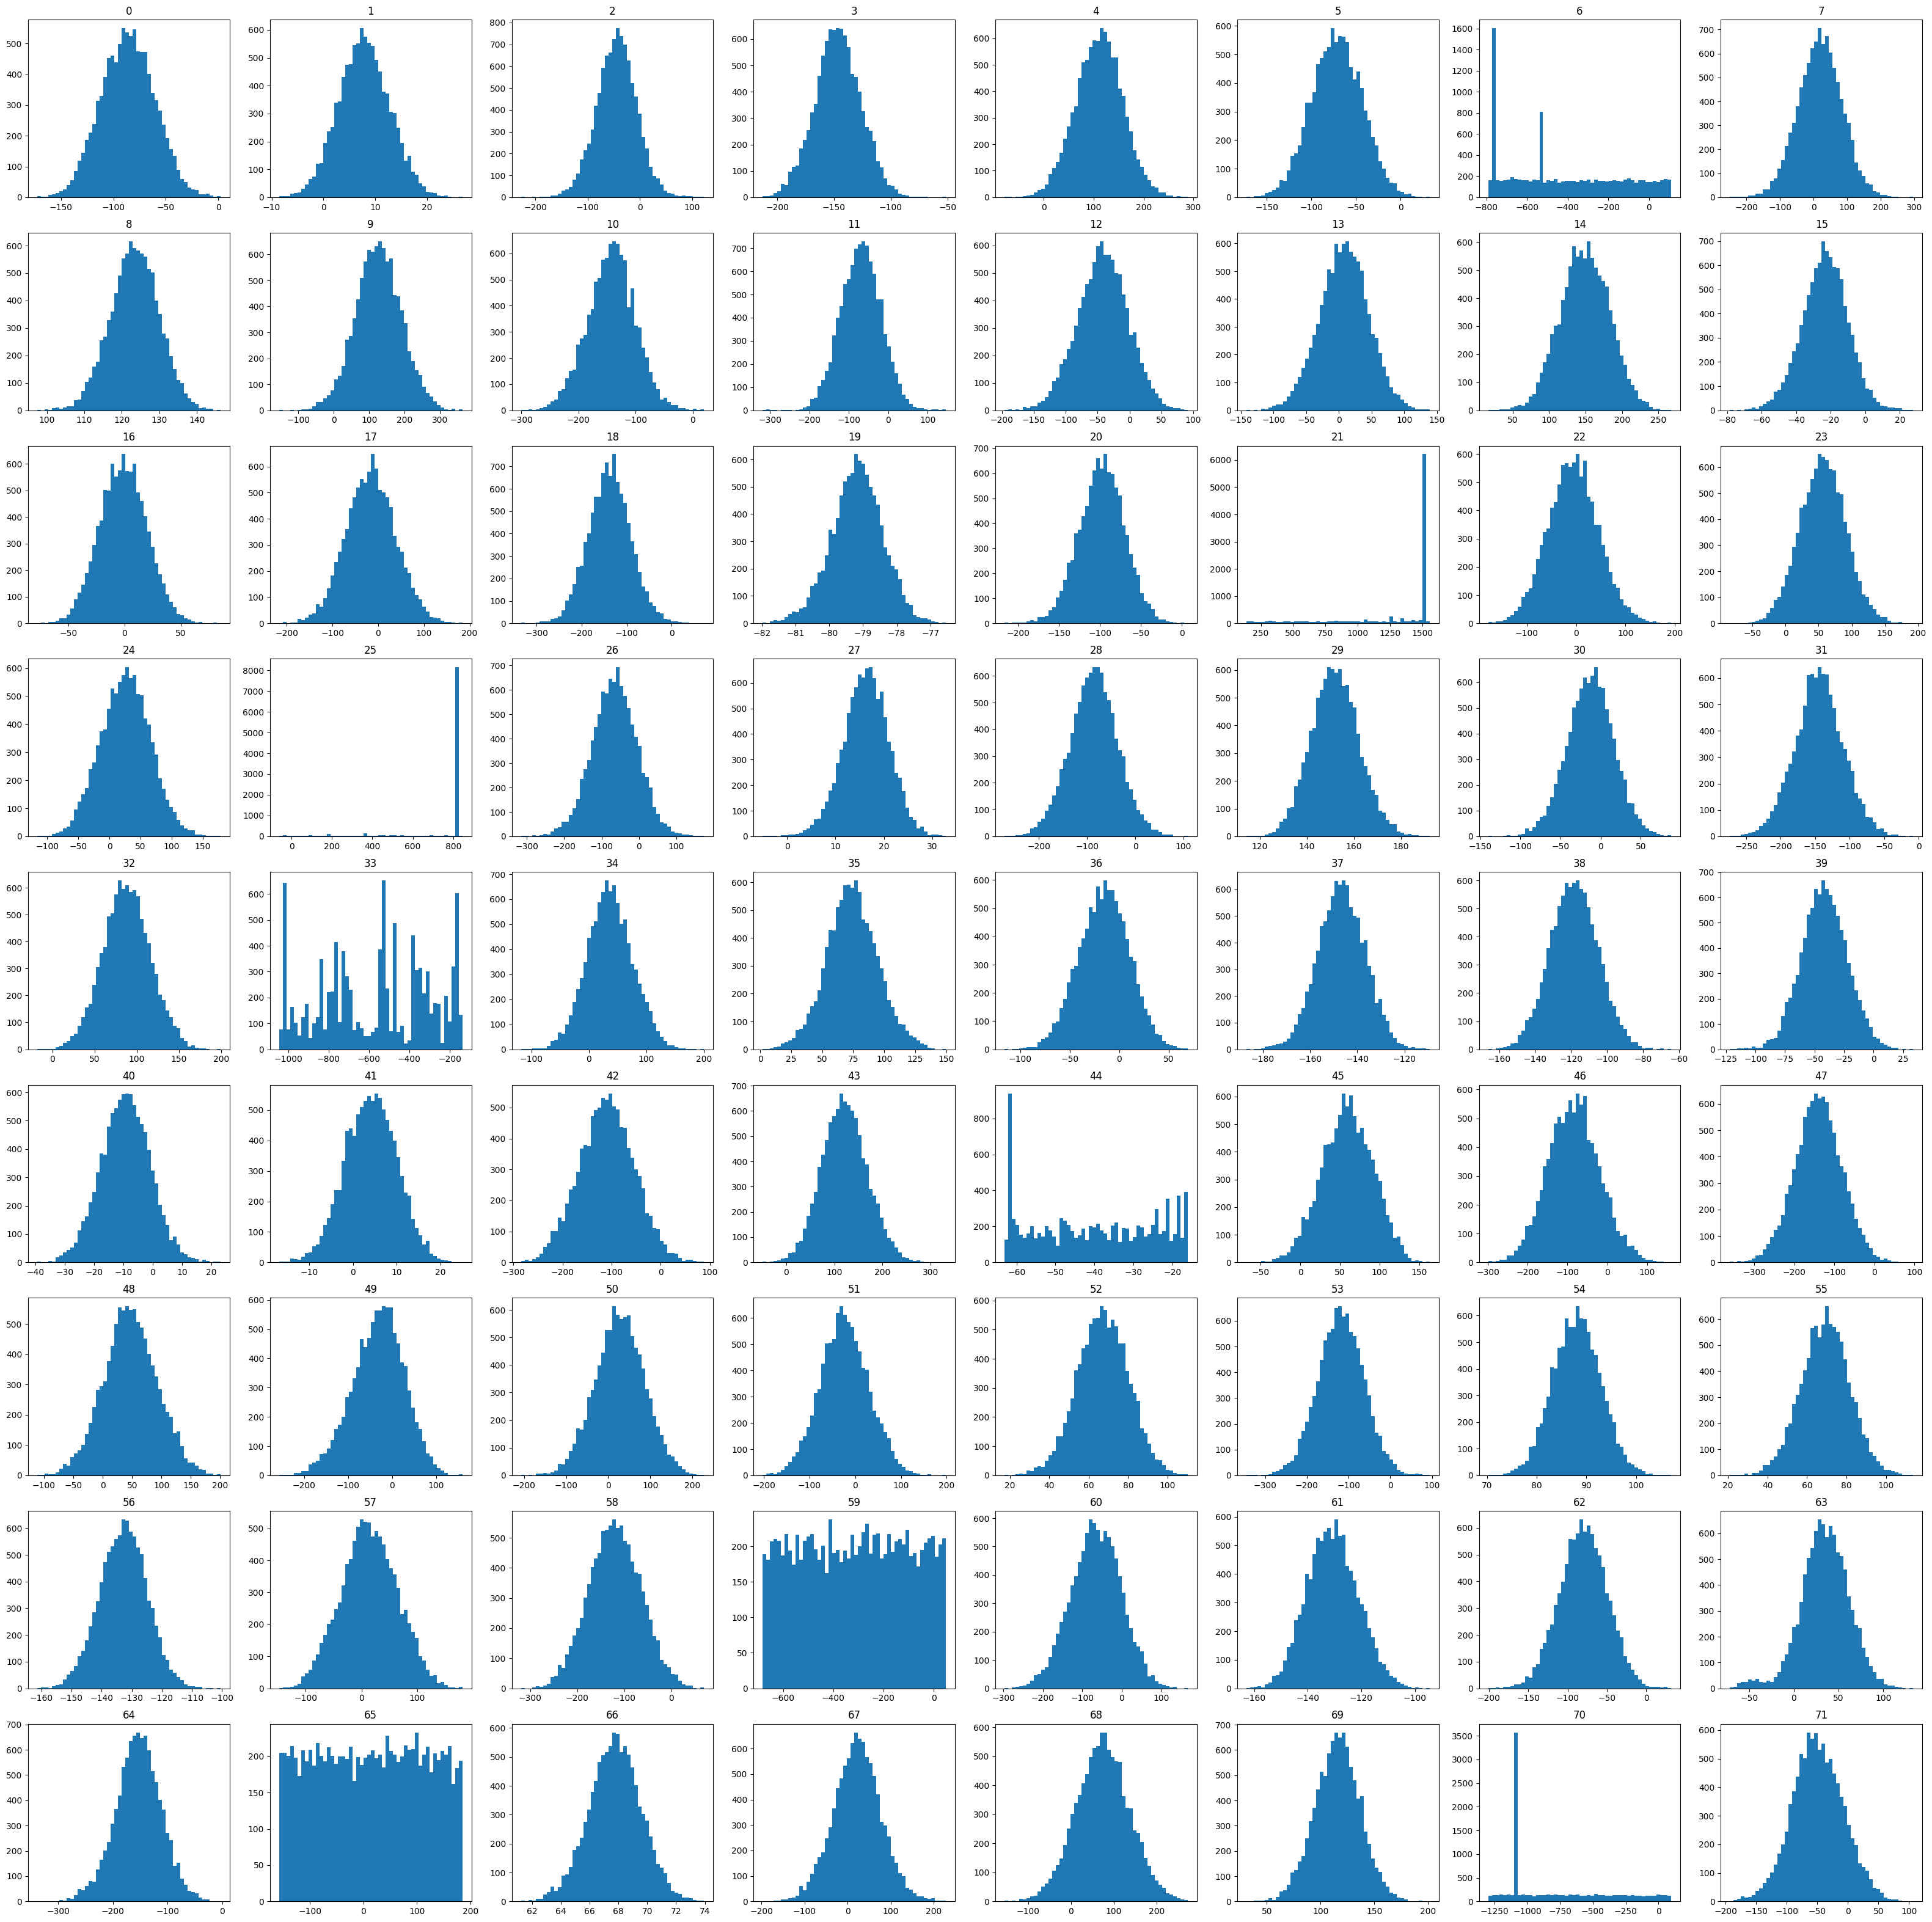

In [9]:
plt.figure(figsize=(40, 40))

for i in range(72):
    plt.subplot(9, 8, i+1)
    plt.hist(data_sample[str(i)], bins=50)
    plt.title(str(i))

plt.show()

In [22]:
data_base.isna().sum().sum()

0

In [23]:
data_base.duplicated().sum()

0

Как видим большинство признаков имеют нормальное распределение, но лежат в разных диапазонах.  
Все признаки необходимо отмасштабировать.  
Большинство значений признаков под номерами 6, 21, 25 и 70 лежат в узких диапазонах, что заставляет задуматься об их информативности. Следует попробовать удалить эти признаки и обучить модель без них. 
Также стоит попробовать обучить модель только на признаках, имеющих нормальное распределение.
Дубликатов и пропусков в датасете не обнаружено.

## Повышение качества модели

### Исследуем различные способы масштабирования признаков

Используем StandardScaler

In [17]:
scaler = StandardScaler()
data_base_scaled = scaler.fit_transform(data_base)
data_train_scaled = scaler.transform(data_train)

In [18]:
dims = data_base_scaled.shape[1]
n_cells = 500
k = 5
quantizer2 = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer2, dims, n_cells)

In [19]:
idx_l2.train(np.ascontiguousarray(data_base_scaled[:50000, :]).astype('float32'))
idx_l2.add(np.ascontiguousarray(data_base_scaled).astype('float32'))

In [20]:
vecs, idx = idx_l2.search(np.ascontiguousarray(data_train_scaled).astype('float32'), k)

In [21]:
accuracy_scaled_1 = accuracy_5(targets, idx, base_index)
accuracy_scaled_1

52.48

Используем Normalizer

In [22]:
scaler = Normalizer()
data_base_scaled = scaler.fit_transform(data_base)
data_train_scaled = scaler.transform(data_train)

In [23]:
dims = data_base_scaled.shape[1]
n_cells = 500
k = 5
quantizer2 = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer2, dims, n_cells)

In [24]:
idx_l2.train(np.ascontiguousarray(data_base_scaled[:50000, :]).astype('float32'))
idx_l2.add(np.ascontiguousarray(data_base_scaled).astype('float32'))

In [25]:
vecs, idx = idx_l2.search(np.ascontiguousarray(data_train_scaled).astype('float32'), k)

In [26]:
accuracy_scaled_2 = accuracy_5(targets, idx, base_index)
accuracy_scaled_2

4.854

Используем RobustScaler

In [27]:
scaler = RobustScaler()
data_base_scaled = scaler.fit_transform(data_base)
data_train_scaled = scaler.transform(data_train)

In [28]:
dims = data_base_scaled.shape[1]
n_cells = 500
k = 5
quantizer2 = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer2, dims, n_cells)

In [29]:
idx_l2.train(np.ascontiguousarray(data_base_scaled[:50000, :]).astype('float32'))
idx_l2.add(np.ascontiguousarray(data_base_scaled).astype('float32'))

In [30]:
vecs, idx = idx_l2.search(np.ascontiguousarray(data_train_scaled).astype('float32'), k)

In [31]:
accuracy_scaled_3 = accuracy_5(targets, idx, base_index)
accuracy_scaled_3

45.95

Лучше всего себя показал StandardScaler, повысив значение метрики accuracy_5 до 52.48

### Попробуем удалить, как мы предполагаем, неинформативные признаки.

In [10]:
data_base_new = data_base.drop(['6', '21', '25', '70'], axis=1)
data_train_new = data_train.drop(['6', '21', '25', '70'], axis=1)

In [11]:
data_base_new.columns

Index(['0', '1', '2', '3', '4', '5', '7', '8', '9', '10', '11', '12', '13',
       '14', '15', '16', '17', '18', '19', '20', '22', '23', '24', '26', '27',
       '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39',
       '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51',
       '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63',
       '64', '65', '66', '67', '68', '69', '71'],
      dtype='object')

In [12]:
scaler = StandardScaler()
data_base_scaled = scaler.fit_transform(data_base_new)
data_train_scaled = scaler.transform(data_train_new)

In [35]:
dims = data_base_scaled.shape[1]
n_cells = 500
k = 5
quantizer2 = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer2, dims, n_cells)

In [36]:
idx_l2.train(np.ascontiguousarray(data_base_scaled[:50000, :]).astype('float32'))
idx_l2.add(np.ascontiguousarray(data_base_scaled).astype('float32'))

In [37]:
vecs, idx = idx_l2.search(np.ascontiguousarray(data_train_scaled).astype('float32'), k)

In [38]:
accuracy_scaled_1 = accuracy_5(targets, idx, base_index)
accuracy_scaled_1

55.066

Удаление неиформативных признаков увеличило метрику до 55.066

Промежуточный итог:
- удаляем признаки 6, 21, 25, 70;
- масштабируем данные используя StandardScaler

### Подбор гиперпараметров модели

Теперь постараемся подобрать гиперпараметры модели, а именно:   
- количество кластеров, на которые разбиваем датасет; 
- количество ближайших к запросу кластеров, из которых будем искать подходящие товары. 

Необходимо создать сетку по количеству кластеров, на которые будем разбивать данные и по количеству кластеров, которые будем использовать для поиска ближайших соседей. Провести поиск оптимальных параметров по сетке.

Создадим сетку параметров

In [17]:
n_clusters = [500, 750, 1000, 1500, 1708, 2000]
n_nearest_clusters = [1, 2, 3, 5, 10, 15, 20, 50, 100]

n_clusters_25 = [25]
n_nearest_clusters_25 = [1, 2, 3]

n_clusters_50 = [50]
n_nearest_clusters_50 = [1, 2, 3, 5, 10]

n_clusters_100 = [100, 250]
n_nearest_clusters_100 = [1, 2, 3, 5, 10, 15, 20]

In [18]:
parameter_grid = []

for i in n_clusters_25:
    for j in n_nearest_clusters_25:
        parameter_grid.append([i, j])

for i in n_clusters_50:
    for j in n_nearest_clusters_50:
        parameter_grid.append([i, j])

for i in n_clusters_100:
    for j in n_nearest_clusters_100:
        parameter_grid.append([i, j])

for i in n_clusters:
    for j in n_nearest_clusters:
        parameter_grid.append([i, j])

parameter_grid

[[25, 1],
 [25, 2],
 [25, 3],
 [50, 1],
 [50, 2],
 [50, 3],
 [50, 5],
 [50, 10],
 [100, 1],
 [100, 2],
 [100, 3],
 [100, 5],
 [100, 10],
 [100, 15],
 [100, 20],
 [250, 1],
 [250, 2],
 [250, 3],
 [250, 5],
 [250, 10],
 [250, 15],
 [250, 20],
 [500, 1],
 [500, 2],
 [500, 3],
 [500, 5],
 [500, 10],
 [500, 15],
 [500, 20],
 [500, 50],
 [500, 100],
 [750, 1],
 [750, 2],
 [750, 3],
 [750, 5],
 [750, 10],
 [750, 15],
 [750, 20],
 [750, 50],
 [750, 100],
 [1000, 1],
 [1000, 2],
 [1000, 3],
 [1000, 5],
 [1000, 10],
 [1000, 15],
 [1000, 20],
 [1000, 50],
 [1000, 100],
 [1500, 1],
 [1500, 2],
 [1500, 3],
 [1500, 5],
 [1500, 10],
 [1500, 15],
 [1500, 20],
 [1500, 50],
 [1500, 100],
 [1708, 1],
 [1708, 2],
 [1708, 3],
 [1708, 5],
 [1708, 10],
 [1708, 15],
 [1708, 20],
 [1708, 50],
 [1708, 100],
 [2000, 1],
 [2000, 2],
 [2000, 3],
 [2000, 5],
 [2000, 10],
 [2000, 15],
 [2000, 20],
 [2000, 50],
 [2000, 100]]

In [19]:
dims = data_base_scaled.shape[1]

Напишем функцию для поиска параметров по сетке

In [20]:
def search_best_param(model:faiss.swigfaiss.IndexIVFFlat,
                      quantizer:faiss.swigfaiss.IndexFlatL2,
                      train:np.array, 
                      test:np.array,
                      targets:pd.Series,
                      base_index:dict,
                      grid:list,
                      dims:int,
                      k:int=5):
    
    best_params = []
    best_accuracy = 0

    for param in tqdm(grid):
        quant = quantizer(dims)
        index = model(quant, dims, param[0])
        index.train(np.ascontiguousarray(train[:100000, :]).astype('float32'))
        index.add(np.ascontiguousarray(train).astype('float32'))
        index.nprobe = param[1]

        vecs_pred, idx_pred = index.search(np.ascontiguousarray(test).astype('float32'), k)

        accuracy = accuracy_5(targets, idx_pred, base_index)

        if accuracy > best_accuracy:
            best_params = param
            best_accuracy = accuracy

        text = f'params: {param} - accuracy: {accuracy}'
        tqdm.write(text)

    print('best accuracy_5:', best_accuracy)
    print('best params:', best_params)

    return best_params

Запустим поиск оптимальных гиперпаметров

In [21]:
params = search_best_param(
         faiss.IndexIVFFlat,
         faiss.IndexFlatL2,
         data_base_scaled,
         data_train_scaled,
         targets,
         base_index,
         parameter_grid,
         dims,
         k=5)

  1%|▏         | 1/76 [02:07<2:39:49, 127.87s/it]

params: [25, 1] - accuracy: 57.257


  3%|▎         | 2/76 [06:35<4:18:46, 209.82s/it]

params: [25, 2] - accuracy: 63.299


  4%|▍         | 3/76 [13:23<6:05:50, 300.70s/it]

params: [25, 3] - accuracy: 64.967


  5%|▌         | 4/76 [14:29<4:09:15, 207.71s/it]

params: [50, 1] - accuracy: 58.225


  7%|▋         | 5/76 [16:42<3:34:16, 181.07s/it]

params: [50, 2] - accuracy: 63.313


  8%|▊         | 6/76 [20:09<3:41:12, 189.61s/it]

params: [50, 3] - accuracy: 64.714


  9%|▉         | 7/76 [25:55<4:36:59, 240.87s/it]

params: [50, 5] - accuracy: 65.616


 11%|█         | 8/76 [37:27<7:15:45, 384.49s/it]

params: [50, 10] - accuracy: 66.178


 12%|█▏        | 9/76 [38:02<5:07:26, 275.32s/it]

params: [100, 1] - accuracy: 58.108


 13%|█▎        | 10/76 [39:12<3:52:56, 211.77s/it]

params: [100, 2] - accuracy: 63.068


 14%|█▍        | 11/76 [40:55<3:13:30, 178.62s/it]

params: [100, 3] - accuracy: 64.453


 16%|█▌        | 12/76 [43:49<3:08:49, 177.02s/it]

params: [100, 5] - accuracy: 65.352


 17%|█▋        | 13/76 [49:36<4:00:08, 228.70s/it]

params: [100, 10] - accuracy: 65.938


 18%|█▊        | 14/76 [58:14<5:26:42, 316.17s/it]

params: [100, 15] - accuracy: 66.143


 20%|█▉        | 15/76 [1:09:36<7:13:15, 426.16s/it]

params: [100, 20] - accuracy: 66.233


 21%|██        | 16/76 [1:09:54<5:03:23, 303.39s/it]

params: [250, 1] - accuracy: 57.199


 22%|██▏       | 17/76 [1:10:25<3:37:58, 221.67s/it]

params: [250, 2] - accuracy: 62.339


 24%|██▎       | 18/76 [1:11:10<2:42:51, 168.47s/it]

params: [250, 3] - accuracy: 63.877


 25%|██▌       | 19/76 [1:12:20<2:12:02, 138.99s/it]

params: [250, 5] - accuracy: 64.927


 26%|██▋       | 20/76 [1:14:35<2:08:32, 137.73s/it]

params: [250, 10] - accuracy: 65.628


 28%|██▊       | 21/76 [1:17:55<2:23:15, 156.27s/it]

params: [250, 15] - accuracy: 65.86


 29%|██▉       | 22/76 [1:22:17<2:49:23, 188.21s/it]

params: [250, 20] - accuracy: 65.998


 30%|███       | 23/76 [1:22:32<2:00:13, 136.10s/it]

params: [500, 1] - accuracy: 55.656


 32%|███▏      | 24/76 [1:22:53<1:28:03, 101.60s/it]

params: [500, 2] - accuracy: 61.214


 33%|███▎      | 25/76 [1:23:20<1:07:23, 79.27s/it] 

params: [500, 3] - accuracy: 63.027


 34%|███▍      | 26/76 [1:23:59<56:01, 67.24s/it]  

params: [500, 5] - accuracy: 64.36


 36%|███▌      | 27/76 [1:25:08<55:13, 67.62s/it]

params: [500, 10] - accuracy: 65.358


 37%|███▋      | 28/76 [1:26:46<1:01:20, 76.67s/it]

params: [500, 15] - accuracy: 65.681


 38%|███▊      | 29/76 [1:28:52<1:11:49, 91.69s/it]

params: [500, 20] - accuracy: 65.853


 39%|███▉      | 30/76 [1:33:53<1:58:22, 154.39s/it]

params: [500, 50] - accuracy: 66.138


 41%|████      | 31/76 [1:43:40<3:33:09, 284.22s/it]

params: [500, 100] - accuracy: 66.301


 42%|████▏     | 32/76 [1:43:55<2:29:10, 203.42s/it]

params: [750, 1] - accuracy: 54.787


 43%|████▎     | 33/76 [1:44:15<1:46:19, 148.36s/it]

params: [750, 2] - accuracy: 60.775


 45%|████▍     | 34/76 [1:44:39<1:17:41, 110.99s/it]

params: [750, 3] - accuracy: 62.761


 46%|████▌     | 35/76 [1:45:10<59:32, 87.13s/it]   

params: [750, 5] - accuracy: 64.246


 47%|████▋     | 36/76 [1:46:01<50:47, 76.19s/it]

params: [750, 10] - accuracy: 65.284


 49%|████▊     | 37/76 [1:47:10<48:07, 74.05s/it]

params: [750, 15] - accuracy: 65.607


 50%|█████     | 38/76 [1:48:38<49:31, 78.21s/it]

params: [750, 20] - accuracy: 65.77


 51%|█████▏    | 39/76 [1:51:59<1:10:56, 115.05s/it]

params: [750, 50] - accuracy: 66.097


 53%|█████▎    | 40/76 [1:58:27<1:58:13, 197.05s/it]

params: [750, 100] - accuracy: 66.253


 54%|█████▍    | 41/76 [1:58:43<1:23:17, 142.78s/it]

params: [1000, 1] - accuracy: 54.046


 55%|█████▌    | 42/76 [1:59:03<59:56, 105.79s/it]  

params: [1000, 2] - accuracy: 60.405


 57%|█████▋    | 43/76 [1:59:26<44:32, 80.98s/it] 

params: [1000, 3] - accuracy: 62.413


 58%|█████▊    | 44/76 [1:59:55<34:49, 65.29s/it]

params: [1000, 5] - accuracy: 64.029


 59%|█████▉    | 45/76 [2:00:38<30:17, 58.62s/it]

params: [1000, 10] - accuracy: 65.125


 61%|██████    | 46/76 [2:01:35<29:03, 58.12s/it]

params: [1000, 15] - accuracy: 65.543


 62%|██████▏   | 47/76 [2:02:46<29:56, 61.95s/it]

params: [1000, 20] - accuracy: 65.718


 63%|██████▎   | 48/76 [2:05:20<41:51, 89.71s/it]

params: [1000, 50] - accuracy: 66.071


 64%|██████▍   | 49/76 [2:10:14<1:07:54, 150.90s/it]

params: [1000, 100] - accuracy: 66.224


 66%|██████▌   | 50/76 [2:10:34<48:25, 111.75s/it]  

params: [1500, 1] - accuracy: 53.04


 67%|██████▋   | 51/76 [2:10:57<35:27, 85.08s/it] 

params: [1500, 2] - accuracy: 59.673


 68%|██████▊   | 52/76 [2:11:22<26:49, 67.07s/it]

params: [1500, 3] - accuracy: 61.954


 70%|██████▉   | 53/76 [2:11:51<21:20, 55.69s/it]

params: [1500, 5] - accuracy: 63.72


 71%|███████   | 54/76 [2:12:30<18:34, 50.67s/it]

params: [1500, 10] - accuracy: 64.931


 72%|███████▏  | 55/76 [2:13:19<17:29, 49.98s/it]

params: [1500, 15] - accuracy: 65.367


 74%|███████▎  | 56/76 [2:14:16<17:26, 52.31s/it]

params: [1500, 20] - accuracy: 65.613


 75%|███████▌  | 57/76 [2:16:11<22:27, 70.92s/it]

params: [1500, 50] - accuracy: 66.02


 76%|███████▋  | 58/76 [2:19:39<33:36, 112.03s/it]

params: [1500, 100] - accuracy: 66.196


 78%|███████▊  | 59/76 [2:20:01<24:07, 85.13s/it] 

params: [1708, 1] - accuracy: 52.601


 79%|███████▉  | 60/76 [2:20:26<17:51, 66.97s/it]

params: [1708, 2] - accuracy: 59.24


 80%|████████  | 61/76 [2:20:52<13:41, 54.75s/it]

params: [1708, 3] - accuracy: 61.637


 82%|████████▏ | 62/76 [2:21:22<11:02, 47.36s/it]

params: [1708, 5] - accuracy: 63.451


 83%|████████▎ | 63/76 [2:22:00<09:41, 44.73s/it]

params: [1708, 10] - accuracy: 64.799


 84%|████████▍ | 64/76 [2:22:47<09:04, 45.38s/it]

params: [1708, 15] - accuracy: 65.255


 86%|████████▌ | 65/76 [2:23:43<08:51, 48.32s/it]

params: [1708, 20] - accuracy: 65.491


 87%|████████▋ | 66/76 [2:25:27<10:50, 65.06s/it]

params: [1708, 50] - accuracy: 65.995


 88%|████████▊ | 67/76 [2:28:33<15:12, 101.37s/it]

params: [1708, 100] - accuracy: 66.171


 89%|████████▉ | 68/76 [2:28:57<10:26, 78.29s/it] 

params: [2000, 1] - accuracy: 52.166


 91%|█████████ | 69/76 [2:29:24<07:19, 62.77s/it]

params: [2000, 2] - accuracy: 59.17


 92%|█████████▏| 70/76 [2:29:52<05:14, 52.41s/it]

params: [2000, 3] - accuracy: 61.535


 93%|█████████▎| 71/76 [2:30:24<03:50, 46.16s/it]

params: [2000, 5] - accuracy: 63.392


 95%|█████████▍| 72/76 [2:31:03<02:56, 44.03s/it]

params: [2000, 10] - accuracy: 64.789


 96%|█████████▌| 73/76 [2:31:49<02:14, 44.74s/it]

params: [2000, 15] - accuracy: 65.236


 97%|█████████▋| 74/76 [2:32:43<01:34, 47.39s/it]

params: [2000, 20] - accuracy: 65.461


 99%|█████████▊| 75/76 [2:34:19<01:01, 61.97s/it]

params: [2000, 50] - accuracy: 65.957


100%|██████████| 76/76 [2:37:06<00:00, 124.04s/it]

params: [2000, 100] - accuracy: 66.158
best accuracy_5: 66.301
best params: [500, 100]


Получили следующие гиперпараметры: 
- количество кластеров на которые разбиваем товары (n_cells): - 500
- количество ближайших кластеров, по которым ищем подбираем товары (nprobe): 100, 50.
Для случая n_cells = 500, nprobe = 100, значение метрики accuracy_5 = 66.301.  
Для случая n_cells = 500, nprobe = 50, значение метрики accuracy_5 = 66.138.  
Как видим, во втором случае мы мало теряем в качестве модели, но значительно выигрываем во времени поска товаров.   
Остановимся на следующих параметрах: n_cells = 500, nprobe = 50.

### Обучим модель на признаках имеющих только нормальное распределение.

In [10]:
data_base_new = data_base.drop(['6', '21', '25', '33', '44', '59', '65', '70'], axis=1)
data_train_new = data_train.drop(['6', '21', '25', '33', '44', '59', '65', '70'], axis=1)
data_validation_new = data_validation.drop(['6', '21', '25', '33', '44', '59', '65', '70'], axis=1)

In [11]:
data_base_new.columns

Index(['0', '1', '2', '3', '4', '5', '7', '8', '9', '10', '11', '12', '13',
       '14', '15', '16', '17', '18', '19', '20', '22', '23', '24', '26', '27',
       '28', '29', '30', '31', '32', '34', '35', '36', '37', '38', '39', '40',
       '41', '42', '43', '45', '46', '47', '48', '49', '50', '51', '52', '53',
       '54', '55', '56', '57', '58', '60', '61', '62', '63', '64', '66', '67',
       '68', '69', '71'],
      dtype='object')

In [14]:
scaler = StandardScaler()
data_base_scaled = scaler.fit_transform(data_base_new)
data_train_scaled = scaler.transform(data_train_new)
data_validation_scaled = scaler.transform(data_validation_new)

In [15]:
data_base_scaled_frame = pd.DataFrame(data_base_scaled, 
                                      columns=data_base_new.columns, 
                                      index=data_base_new.index)

data_train_scaled_frame = pd.DataFrame(data_train_scaled, 
                                       columns=data_train_new.columns, 
                                       index=data_train_new.index)

data_validation_scaled_frame = pd.DataFrame(data_validation_scaled, 
                                            columns=data_validation_new.columns, 
                                            index=data_validation_new.index)

In [16]:
dims = data_base_scaled.shape[1]
n_cells = 500
quantizer2 = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer2, dims, n_cells)

idx_l2.train(np.ascontiguousarray(data_base_scaled[:50000, :]).astype('float32'))
idx_l2.add(np.ascontiguousarray(data_base_scaled).astype('float32'))
idx_l2.nprobe = 50

vecs, idx = idx_l2.search(np.ascontiguousarray(data_train_scaled).astype('float32'), 5)

In [17]:
accuracy_scaled_1 = accuracy_5(targets, idx, base_index)
accuracy_scaled_1

70.744

Как видим, качество модели увеличилось на 4%, по сравнению с прошлым результатом.

На данном этапе имеем следующее:
- модель обучаяем только на признаках, имеющих нормальное распределение;  
- признаковое описание масштабируем с помощью StandardScaler;  
- для модели используем слудующие гиперпараметры: n_cells = 500, nprobe = 50.

## Реализация второго этапа ранжирования.

В качестве модели для второго этапа ранжирования будем использовать классификатор на основе градиентного бустинга

Забегая вперед, опишу выводы полученные по этому разделу:  
- Повысить качество матчинга не удалось. В самом лучшем случае вторая модель уменьшала качество на 1%, до 69%. Может где-то допустил ошибку, но найти ее я не смог.  
- Для проверки качества матчинга использовал первые 5000 векторов из validatuon.csv.
- В качестве тренировочного датасета для градиентного бустинга использовал сконкатенированный набор векторов:  
    - в качестве объектов класса 1 конкатенацию запросных векторов из train.csv, для которых индекс неверно предсказывал ближайшие вектора, то   есть в топ 5 таргет не попадал, и целевого вектора из base.csv.
    - в качестве объектов класса 0 конкатенацию запросных векторов из train.csv, также для которых индекс неверно предсказывал ближайшие вектора, и первый ближайший предсказанный индексом товар из base.csv.
Таким образом получал сбалансированный датасет, на котором были лучшие результаты, качество матчинга ухудшалось всего на 1%.   
Также пробовал обучать на всех запросных векторах с train.csv, где конкатенировал вектор запроса с целевым вектором из base.csv для класса 1 и с 4-5 другими векторами, которые выдавал индекс как ближайшие, для класса 0. В этом случае использовал взвешенные классы, но качество матчинга было хуже, чем в первом случае.  
- Для каждого запросного вектора из train.csv с помощью индекса предсказывал 500 ближайших векторов из base.csv, поскольку в этом случае целевой вектор с вероятностью примерно 84% попадал в предсказанные индексом. Но модель градиентного бустинга всего в 3% случаев ранжировала эти 500 векторов таким образом, чтобы таргет попал в топ 5. Собственно это не позволяла превысить качество индекса в 70%.  
- Также пробовал переранжировать не все вектора предсказанные индексом, а начиная со второго или третьего, поскольку в 55% и 59% случаях таргет попадал в топ 1 и топ 2 соответственно. В данном случае градиентный бустинг повышал качество до 58% и 62% соответственно.  
- Также были попытки изменять количество предсказанных ближайших векторов для каждого вектора запроса. Использовались следующие значения: 20, 50, 100, 500, 1000. Во всех случаях не удалось повысить качество модели.
- Еще пробовал обучать градиентный бустинг на исходных данных, без удаления признаков не имеющих нормальное распрделение и без масштабирования. В этом случае качество самого бустинга росло (precision и recall для обоих классов возростал до 0.9). Индекс предсказывал ближайшие вектора размерностью 64. А для бустинга конкатенировал и подовал вектора размерностью 72, таким образом сконкатенированный вектор имел размерность 144. Но качесвто матчинга только падало, что в принципе странно, поскольку модель бустинга обученная на исходном датасете, лучше распозновала ближайшие вектора. 

Функция, формирующая датасет для обучения градиентного бустинга.

In [18]:
def get_true_false_vector(quries, targets, prediction, base, indexes):
    
    true_vector = [] # вектора класса 1
    false_vector = [] # вектора класса 0

    for query, target, pred, in zip(quries.index, targets.values.tolist(), prediction.tolist()):
        
        # конкатенируем вектор запроса и целевой вектор из base,
        # также добавляем целевую переменную в конец признаквого описания,
        # и добавляем сконкатенированный вектор в true_vector
        true_vector.append(np.hstack((quries.loc[query].values,
                                      base.loc[target].values, 
                                      np.ones([1]))))
        
        # проходимся циклом по всем предсказанным векторам
        for r in pred:
            # если предсказанный вектор не совпадает с целевым,
            # конкатенироуем его с запросным, добавляем целевую переменную
            # и добавляем конечный вектор в false_vector
            if target != indexes[r]:
                false_vector.append(np.hstack((quries.loc[query].values, 
                                               base.loc[indexes[r]].values, 
                                               np.zeros([1]))))
                
    # соединяем true_vector и false_vector в один numpy массив
    true_false_vector = np.vstack((np.array(true_vector),
                                   np.array(false_vector)))
    
    # перемешиваем массив
    np.random.shuffle(true_false_vector)

    return true_false_vector

Та же функция для создания обучающего датасета. Использовать будем только те случаи, когда индекс не верно предсказал наиболее похожие товары, то есть таргет не попал в топ 5.

In [19]:
def get_true_false_vector_2(quries, targets, prediction, base, indexes):
    
    true_vector = []
    false_vector = []

    for query, target, pred, in zip(quries.index, targets.values.tolist(), prediction.tolist()):
    
        if target not in [indexes[r] for r in pred]:

            true_vector.append(np.hstack((quries.loc[query].values, 
                                          base.loc[target].values, 
                                          np.ones([1]))))
        
            for r in pred[:1]:
                
                false_vector.append(np.hstack((quries.loc[query].values, 
                                               base.loc[indexes[r]].values, 
                                               np.zeros([1]))))
                
    true_false_vector = np.vstack((np.array(true_vector),
                                   np.array(false_vector)))
    
    np.random.shuffle(true_false_vector)

    return true_false_vector

In [20]:
true_false_vector = get_true_false_vector_2(data_train_scaled_frame,
                                            targets,
                                            idx,
                                            data_base_scaled_frame,
                                            base_index)

In [21]:
true_false_vector[:, -1].sum() / true_false_vector.shape[0]

0.5

In [22]:
true_false_vector.shape

(58512, 129)

Разделим датасет на признаковое описание и целевую переменную и затем на тренировочную и тестовую выборки. Обучим модель градиентного бустинга

In [23]:
X = true_false_vector[:, :-1]
y = true_false_vector[:, -1]

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, 
                                                    random_state=42,
                                                    stratify=y)

Посчитаем весса классов 

In [249]:
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

Определим модель градиентного бустинга

In [25]:
#model_cb = cb.CatBoostClassifier(class_weights=class_weights)
model_cb = cb.CatBoostClassifier()

обучим модель

In [26]:
model_cb.fit(X_train, y_train, verbose=False)

Оценим качество модели

In [27]:
prediction = model_cb.predict(X_test)
accuracy_score(y_test, prediction)

0.8512441892261416

In [28]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

         0.0       0.83      0.89      0.86      7314
         1.0       0.88      0.81      0.85      7314

    accuracy                           0.85     14628
   macro avg       0.85      0.85      0.85     14628
weighted avg       0.85      0.85      0.85     14628



Теперь проверим насколько вырастит качество ранжирования при использовании градиентного бустинга

Для начала проверим, какое качество покажет сам индекс на валидационном датасете.

In [29]:
data_answer_new = pd.Series(data_answer.values.reshape((100000)), index=data_answer.index)

In [30]:
vecs_usl, idx_usl = idx_l2.search(np.ascontiguousarray(data_validation_scaled).astype('float32'), 5)

In [31]:
accuracy_val = accuracy_5(data_answer_new, idx_usl, base_index)
accuracy_val

70.637

Качество индекса на валидационном датасете сохраняется

Создадим срез валидационного датасета, для проверки градиентного бустинга.

In [32]:
data_validation_slice = data_validation_scaled_frame.iloc[:5000]

Предскажем 500 ближайших векторов для каждого вектора запроса. 

In [33]:
vecs_new, idx_new = idx_l2.search(np.ascontiguousarray(data_validation_slice.values).astype('float32'), 500)

In [34]:
# массив переранжированных индексов предсказанных векторов
sort_idx = []

# пройдемся циклом по индексам запросных векторов
for num, i in enumerate(data_validation_slice.index):
    query_set = [] # массив сконкатенированных векторов, который будем подавать бустингу
    #проходимся циклом по каждому предсказанному индексом вектору 
    for j in idx_new[num]:
        # добавляем в query_set вектор запроса сконкатенированный с предсказанным вектором
        # из base.csv на который ссылаемся через base_index
        query_set.append(np.hstack((data_validation_slice.loc[i].values, 
                                    data_base_scaled_frame.loc[base_index[j]].values)))
    
    # переводим query_set в numpy массив
    query_set = np.array(query_set)
    # предсказываем вероятность принадлежности к классу 1
    prob_query = model_cb.predict_proba(query_set)[:, 0]
    # изменим форму массив, чтобы их можно было сконкатенировать
    prob_query = np.array(prob_query).reshape((500, 1))
    idx_r = idx_new[num].reshape((500, 1))
    # конкатенируем предсказанные индексы векторов с вероятностями принадлежности к классу 1
    query_prob_idx = np.hstack((idx_r, prob_query))
    # сортируем query_prob_idx по вероятности, то есть по второму столбцу, в порядке убывания
    # берем срез первых 5 значений 0-го столбца и добавляем в sort_idx
    sort_idx.append(query_prob_idx[query_prob_idx[:, 1].argsort()[::-1]][:5, 0])
    
sort_idx = np.array(sort_idx)

In [35]:
sort_idx

array([[1037237.,  462353., 1954150., 1243148., 2177660.],
       [1902634.,   11829.,  157966.,  847800., 2259158.],
       [ 431806.,   24989.,  451870.,  148400.,  365989.],
       ...,
       [2472179.,  443670.,  972006., 1615244.,  397147.],
       [ 449214.,  158674.,  594493.,  981756.,  203042.],
       [ 285965., 1059921., 1024828., 1658231., 1749898.]])

Рассчитаем accuracy_5

In [36]:
accuracy_val = accuracy_5(data_answer_new[:5000], sort_idx, base_index)
accuracy_val

66.88

Выводы по данному разделу в его начале. Тут больше добавить нечего

## Выводы по проекту

- В качестве финальной модели для матчинга выбран индекс IndexIVFFlat (инвертированный файл с сохраненными векторами) библиотеки faiss с квантователем с метрикой расстояния L2. При этом пространство векторов разбивается на 500 кластеров, а для поиска ближайших векторов к вектору запроса берутся 50 кластеров соответствующих 50 ближайшим центроидам.
- В ходе исследования также сделан вывод, что из признакового описания товаров необходимо удалить признаки, имещие не нормальное распределение, таким образом размерность векторов сокращается до 64. Также оставшиеся признаки необходимо отмасштабировать с помощью StandardScaler.
- Максимальное значение метрики accuracy@5, котого удалось достичь на валидационном датасете, составляет 70.637.  
- Использование классификатора на основе модели градиентного бустинга в качестве второй ранжирующей модели не позволило повысить качество целевой метрики.  